# Shreeya Pahune
## 2018113011

# Ising Model
Ising model is one of the more famous models in statistical physics. The system studied in the model has 'spins' located at vertices of a (possibly infinite) lattice, and spins interact with their neighbours using a specific rule (like spins stabilize the energy and unlike spins destabilize the energy) and iteract with external field B; thus  the energy of the system is given as: 
$$ U = - \sum_i B\sigma_i - \frac{1}{2} \sum_{\langle i,j \rangle} J \sigma_i \sigma_j
$$
In the simple version of the model, $\sigma_i = \pm 1$, and system is maintained at temperature $T$; the probability of a particular configuration is given by the Boltzmann Probability Law:
    $$ P(\{\sigma_i\}_{i=1}^N) \propto \exp\left[-\beta U(\{\sigma_i\})\right]
$$

Clearly the probability is then given by 
$$ P(\{ \sigma_i\}_{i=1}^N) \propto \exp\left[ \frac{B}{kT} \sum_i \sigma_i + \frac{J}{2kT}\sum_{\langle i,j\rangle} \sigma_i \sigma_j    \right]
$$
and hence depends on numerical values of  $\frac{B}{kT}$ and $\frac{J}{2kT}$. 

## Periodic Boundary Conditions
To simulate a infinite system, it is common to use Periodic Boundary Conditions (PBC). As illustraition consider 1-dimensional (1D) lattice, which is nothing but a straight line, with $N$ spins placed with equal spacing between two contigious spins. This chain of spins has left-end and right-end making this a finite system; however if we place this chain of spins on a circle such that in addition to requiring that distance between contigious spins is 1 unit, we require the distance betwen left-end and right-end of chain is 1 unit. We now see that the chain becomes *infinite*.

You can imagine similar trick in 2 dimensions, by requiing PBC in x-direction and y-directions. And, in 3-dimensions, requiring PBC in x-direction, y-direction and z-directions. 

### A specific trick applicable only for Ising Model for periodic boundary conditions
Add one extra row and one extra column to the configuration; the additional column/row is the copy of first column/row. 

## For Ising model, write following functions. Assume 2-dimensional model.
Set $J=1$ without loss of generality. See http://web.mit.edu/krish_s/www/files/ising_Model.pdf  page-27 has $m\, vs\, T$ plot

1. Write function to compute energy (using periodic boundary conditions): `Ising2D_Energy`
3. Write a function for magnetisation `Ising_Magnetisation` for $m(T,B)$
4. Write a function for computing heat capacity `Ising_HeatCapacity` for $C_V(T,B)$: $$C_V = \frac{1}{k_B T^2}\langle (E-\bar{E})^2\rangle = \frac{1}{k_B T^2} \left( \langle E^2 \rangle - \langle E \rangle^2 \right)$$
5. Write a function `Ising_SingleFlip_Metropolis` to perform one step of Metroplis Monte Carlo simulation
6. Write a function  `Ising_StoreConfig` to store configuration
7. Perform Monte Carlo Simulation of Ising Model
8. Plot $m(T,B=0)$ vs. $kT/J$. Hint: $kT/J \approx 2.5$ for critical temperature of Ising model. 

In [3]:
import numpy as np
import scipy.constants as const
import matplotlib.pyplot as plt

In [7]:
class ising_2D():
    ''' Class with attributes and methods to define Ising Model in 2D '''

    def __init__(self, r, c, B, J, T):
        ''' Constructor '''
        self.dimR = r
        self.dimC = c
        
        self.N = r*c
        self.energy = 0
        self.heatCap = 0
        
        self.Config = np.ones((r, c), dtype=int)
        
        self.mu = 1.0
        self.k = 1.0
    
        self.B = B
        self.J = J
        self.T = T
    
    def __str__(self):
        ''' To print only the Config '''
        return str(self.Config)
    
    def intialise_config(self): 
        ''' generates a random spin configuration for initial condition '''
        self.Config = np.random.choice([-1, 1], size=(self.dimR, self.dimC))
    
    def magnetisation(self):
        ''' Compute Magntisation '''    
        return (self.mu * np.sum(self.Config))/self.N
    
    def calcEnergy(self):
        ''' Compute Energy'''    
        self.energy =  self.B * np.sum(self.Config)
        
        TotalE = 0
        for a in range(self.dimR):
            for b in range(self.dimC):
                neighborSum = self.Config[(a+1)%self.dimR,b] + self.Config[a,(b+1)%self.dimC] + self.Config[(a-1)%self.dimR,b] + self.Config[a,(b-1)%self.dimC]
#               neighborSum *= self.Config[a,b]*self.J
                TotalE += neighborSum*self.Config[a,b]*self.J
        
        self.energy += TotalE/2 
#         print(x, self.energy)
        
    def monteCarlo(self):
        ''' Compute MC move '''            
        a = np.random.randint(self.dimR)
        b = np.random.randint(self.dimC)

#         self.Config[a,b] *= -1
        neighborSum = self.Config[(a+1)%self.dimR,b] + self.Config[a,(b+1)%self.dimC] + self.Config[(a-1)%self.dimR,b] + self.Config[a,(b-1)%self.dimC]
        
        delE = 2*(self.B*np.sum(self.Config) + self.J*neighborSum*self.Config[a, b])
    
        if(np.random.random() <= np.exp(-delE/(self.k*self.T))):
            accept=1
            self.Config[a,b] *=-1             
        else:
            accept=0
            
#         self.calcEnergy()
#         e2 = x.energy
        
#         print("delE: ", delE)
#         print("E2-E1: ", e2-e1)
        return accept

    def heatCapacity(self):  # func 1
        ''' Compute Heat Capacity '''
        E_sq = 0
        TotalE = 0
        for a in range(self.dimR):
            for b in range(self.dimC):
                u = self.Config[a][b] * self.B 
                u += self.J  * self.Config[a][b] * (self.Config[(a+1)%self.dimR,b] + self.Config[a,(b+1)%self.dimC] + self.Config[(a-1)%self.dimR,b] + self.Config[a,(b-1)%self.dimC])
                TotalE += u
                E_sq += u ** 2
        self.heatCap =  (1 / (const.k * self.T**2)) * (E_sq - TotalE**2) 
        
    def Heat_capacity1(self):  # func 2
        E=[];
        E2=[];
        for i in range(100):
            self.monteCarlo()
            self.calcEnergy()
            value=self.energy;
            E.append(value);
            E2.append(value*value);
        avg_E2=(np.sum(E2)/1000);
        avg_E=(np.sum(E)/1000);
        return (avg_E2-avg_E**2)/(self.T**2)


In [10]:
import unittest

class Test(unittest.TestCase):
    
    def test_energy_1(self):
        x = ising_2D(50, 50, 0, 1, 300)
        x.calcEnergy()
        self.assertEqual(x.energy, 5000)
    
    def test_energy_2(self):
        x = ising_2D(2, 2, 0, 1, 300) 
        x.Config = np.array([[-1, 1], [1, -1]])
        x.calcEnergy()
        self.assertEqual(x.energy, -8.0)
        
if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

..
----------------------------------------------------------------------
Ran 2 tests in 0.074s

OK


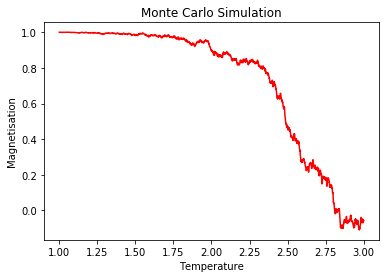

In [14]:
x = ising_2D(50, 50, 0, 1, 3)

# Magnetisation vs Temperature

yar = []
for i in np.linspace(1,3,2000):
    x.T = i 
    mag = 0
    for j in range(300):
        x.monteCarlo()
        mag += x.magnetisation()
    yar = np.append(yar, mag / 300)

plt.xlabel("Temperature")
plt.ylabel("Magnetisation")
plt.title("Monte Carlo Simulation")
plt.plot(np.linspace(1,3,len(yar)),yar , color= 'r')


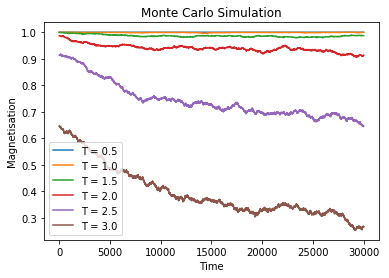

In [32]:
x = ising_2D(50, 50, 0, 1, 0.5)

# Magnetisation vs Time

for j in np.linspace(0.5,3,6):
    yar = []
    x.T = j 
    for i in range(30000):
            x.monteCarlo()
            yar = np.append(yar, x.magnetisation())
    
    plt.xlabel("Time")
    plt.ylabel("Magnetisation")
    plt.title("Monte Carlo Simulation")
    plt.plot(yar , label = 'T = ' + str(j))
plt.legend()

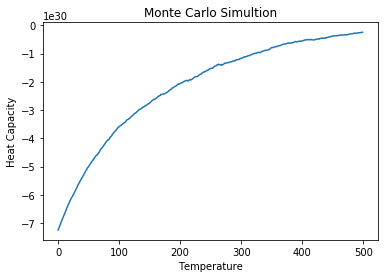

In [19]:
x = ising_2D(50, 50, 0, 1, 0.5)

# Heat_Capacity vs time using function 1 of Heat Capacity

yar=[]
for i in np.linspace(1,3,500):
    x.T = i 
    for j in range(100):
            x.monteCarlo()
    x.heatCapacity()
    yar = np.append(yar,x.heatCap)

plt.xlabel("Temperature")
plt.ylabel("Heat Capacity")
plt.title("Monte Carlo Simultion")
plt.plot(yar)

..........

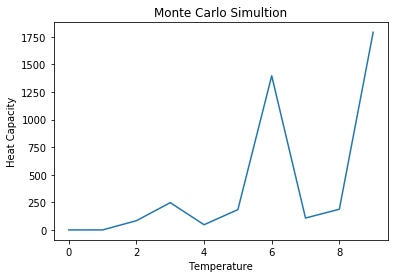

In [14]:
x = ising_2D(50, 50, 0, 1, 0.5)

# Heat_Capacity vs time using function 2 of Heat Capacity

yar=[]
for i in np.linspace(1,3,10):
    x.T = i 
#     for j in range(1000):
#         x.monteCarlo()
    yar = np.append(yar,x.Heat_capacity1())
    print(".", end='')

plt.xlabel("Temperature")
plt.ylabel("Heat Capacity")
plt.title("Monte Carlo Simultion")
plt.plot(yar)